In [1]:
# Importowanie potrzebnych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

class DataLoader:
    def __init__(self, url):
        # Inicjalizacja klasy DataLoader z URL-em danych
        self.url = url
        self.data = None

    def load_data(self):
        # Wczytywanie danych z pliku CSV
        self.data = pd.read_csv(self.url, sep=';')
        return self.data


In [2]:
class DataProcessor:
    def __init__(self, data):
        # Inicjalizacja klasy DataProcessor z wczytanymi danymi
        self.data = data
        self.data_scaled = None

    def initial_analysis(self):
        # Wykonanie wstępnej analizy danych: informacja o danych, statystyki opisowe, sprawdzenie brakujących wartości
        print(self.data.info())
        print(self.data.describe())
        print(self.data.isnull().sum())

    def visualize_data(self):
        # Wizualizacja danych: histogramy, macierz korelacji, wykresy pudełkowe
        self.data.hist(bins=20, figsize=(10,10))
        plt.show()

        correlation_matrix = self.data.corr()
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.show()

        plt.figure(figsize=(12, 8))
        sns.boxplot(x='quality', y='alcohol', data=self.data)
        plt.show()

    def normalize_data(self):
        # Normalizacja danych (bez kolumny 'quality') za pomocą StandardScaler
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(self.data.drop(columns='quality'))
        self.data_scaled = pd.DataFrame(data_scaled, columns=self.data.columns[:-1])
        self.data_scaled['quality'] = self.data['quality']

    def categorize_labels(self):
        # Kategoryzacja etykiet: zamiana wartości w kolumnie 'quality' na 1 dla jakości >= 6, w przeciwnym razie 0
        self.data_scaled['quality'] = self.data_scaled['quality'].apply(lambda x: 1 if x >= 6 else 0)

    def get_processed_data(self):
        # Zwrócenie przetworzonych danych
        return self.data_scaled


In [3]:
class ModelTrainer:
    def __init__(self, X, y):
        # Inicjalizacja klasy ModelTrainer z danymi wejściowymi i etykietami
        self.X = X
        self.y = y
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000),
            'Random Forest': RandomForestClassifier(),
            'SVM': SVC(probability=True)
        }
        self.best_model = None
        self.best_model_name = ''
        self.best_params = {}
        self.initial_results = {}

    def train_models(self):
        # Trenowanie modeli: Logistic Regression, Random Forest, SVM
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

        for name, model in self.models.items():
            # Trenowanie modelu
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else np.zeros(len(y_test))
            accuracy = accuracy_score(y_test, y_pred)
            self.initial_results[name] = accuracy
            print(f"{name} Accuracy: {accuracy}")
            print(classification_report(y_test, y_pred))

            # Wykres ROC i AUC
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic - {name}')
            plt.legend(loc='lower right')
            plt.show()

        # Wybór najlepszego modelu na podstawie dokładności
        self.best_model_name = max(self.initial_results, key=self.initial_results.get)
        self.best_model = self.models[self.best_model_name]
        print(f"Selected best initial model: {self.best_model_name}")

    def fine_tune_model(self):
        # Dostrajanie najlepszego modelu za pomocą GridSearchCV
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

        param_grids = {
            'Logistic Regression': {'C': [0.1, 1, 10]},
            'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
            'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
        }

        grid_search = GridSearchCV(self.best_model, param_grids[self.best_model_name], cv=5)
        grid_search.fit(X_train, y_train)
        self.best_params = grid_search.best_params_
        print(f"Best parameters for {self.best_model_name}: {self.best_params}")
        self.best_model = grid_search.best_estimator_

        # Ocena najlepszego modelu po dostrojeniu
        y_pred_best = self.best_model.predict(X_test)
        print(f"Best {self.best_model_name} Accuracy: {accuracy_score(y_test, y_pred_best)}")
        print(classification_report(y_test, y_pred_best))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.00000

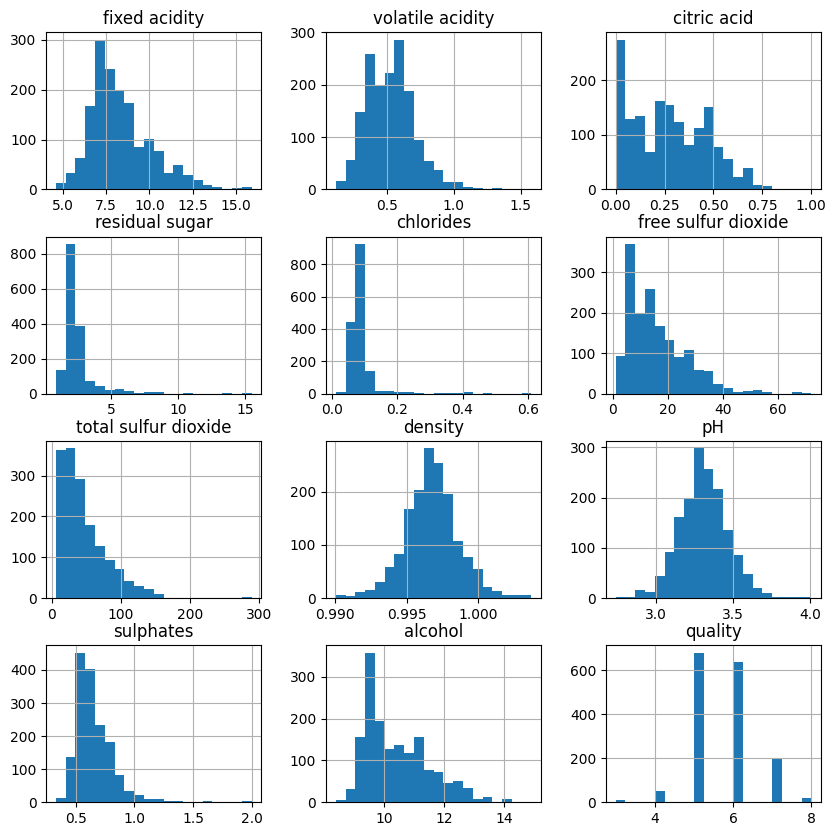

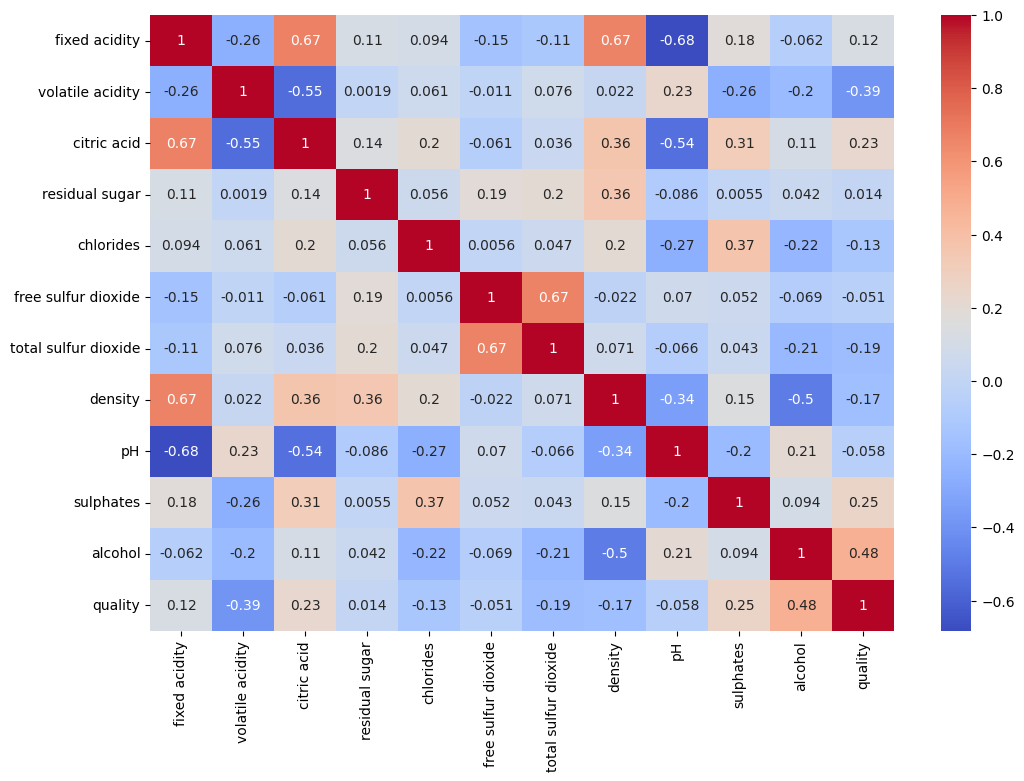

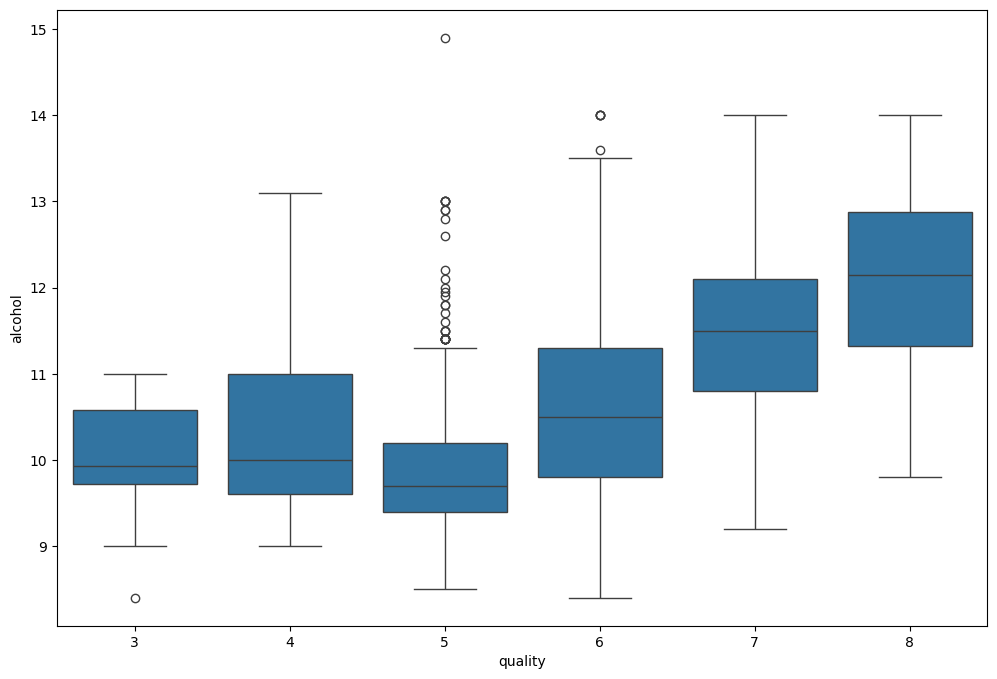

Logistic Regression Accuracy: 0.740625
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       141
           1       0.79      0.74      0.76       179

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



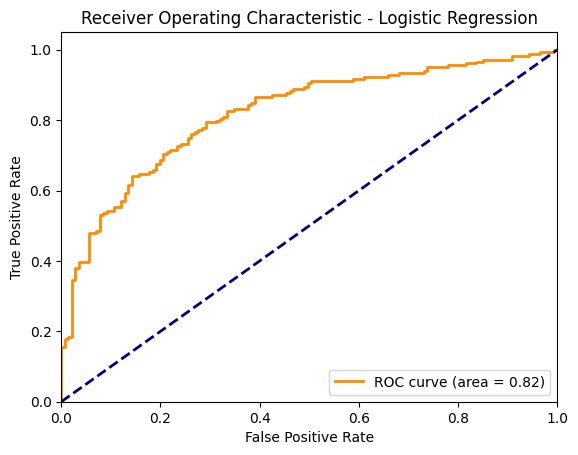

Random Forest Accuracy: 0.80625
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       141
           1       0.83      0.83      0.83       179

    accuracy                           0.81       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.81      0.81      0.81       320



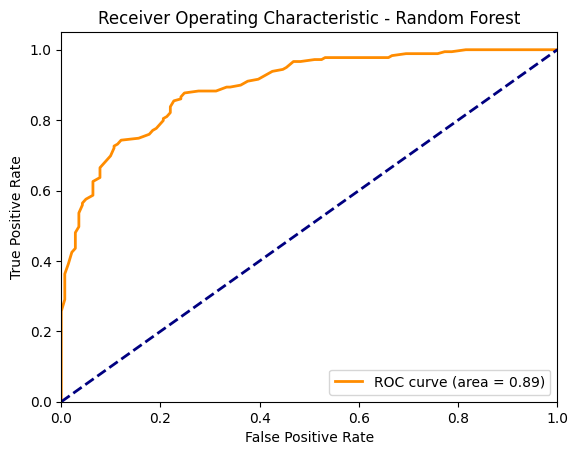

SVM Accuracy: 0.771875
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       141
           1       0.81      0.77      0.79       179

    accuracy                           0.77       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.77      0.77       320



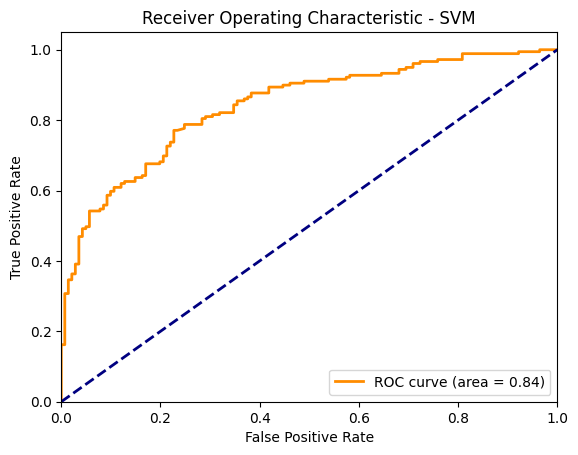

Selected best initial model: Random Forest
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best Random Forest Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       141
           1       0.83      0.81      0.82       179

    accuracy                           0.80       320
   macro avg       0.80      0.80      0.80       320
weighted avg       0.80      0.80      0.80       320



In [4]:
# Główna część programu
data_loader = DataLoader('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv')
data = data_loader.load_data()

data_processor = DataProcessor(data)
data_processor.initial_analysis()
data_processor.visualize_data()
data_processor.normalize_data()
data_processor.categorize_labels()
processed_data = data_processor.get_processed_data()

X = processed_data.drop(columns='quality')
y = processed_data['quality']

model_trainer = ModelTrainer(X, y)
model_trainer.train_models()
model_trainer.fine_tune_model()


In [5]:
# Importowanie potrzebnych bibliotek do testów
import unittest
from sklearn.metrics import accuracy_score

class TestDataProcessing(unittest.TestCase):
    def setUp(self):
        # Przygotowanie środowiska testowego
        self.data_processor = data_processor
        self.model_trainer = model_trainer

    def test_scaler(self):
        # Sprawdzenie, czy dane są odpowiednio przeskalowane
        for column in self.data_processor.data_scaled.drop(columns='quality').columns:
            self.assertAlmostEqual(self.data_processor.data_scaled[column].mean(), 0, places=1)
            self.assertAlmostEqual(self.data_processor.data_scaled[column].std(), 1, places=1)

    def test_model_accuracy(self):
        # Sprawdzenie, czy dokładność modelu jest na akceptowalnym poziomie
        X_train, X_test, y_train, y_test = train_test_split(self.model_trainer.X, self.model_trainer.y, test_size=0.2, random_state=42)
        self.model_trainer.fine_tune_model()
        self.assertGreater(accuracy_score(y_test, self.model_trainer.best_model.predict(X_test)), 0.7)

# Uruchomienie testów
unittest.main(argv=[''], verbosity=2, exit=False)


test_model_accuracy (__main__.TestDataProcessing) ... ok
test_scaler (__main__.TestDataProcessing) ... ok

----------------------------------------------------------------------
Ran 2 tests in 23.270s

OK


Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best Random Forest Accuracy: 0.796875
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       141
           1       0.82      0.82      0.82       179

    accuracy                           0.80       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.80      0.80      0.80       320

